# IMDB Model Comparison: Flatten vs LSTM vs GRU vs Conv1D (Self-contained)

This notebook compares four architectures on IMDB Reviews using **TextVectorization** so it runs locally in VS Code/Jupyter without external vocab files.
- Baseline **Flatten** after Embedding
- **BiLSTM**
- **BiGRU**
- **Conv1D + GlobalAveragePooling1D**


## Imports

In [1]:
%pip install tensorflow-datasets

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
print('TensorFlow', tf.__version__)

Note: you may need to restart the kernel to use updated packages.


2025-09-08 22:29:09.851967: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-08 22:29:09.852967: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-08 22:29:09.872136: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-08 22:29:09.885599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757345349.901497    6362 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757345349.90

TensorFlow 2.19.1


## Load IMDB (tfds)

In [2]:
(train_ds, test_ds), info = tfds.load(
    'imdb_reviews', split=['train','test'], as_supervised=True, with_info=True
)
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='/home/milzon/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInf

2025-09-08 22:29:23.474877: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Vectorize text

In [3]:
VOCAB_SIZE = 10000
SEQ_LEN = 200
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

vectorize = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, output_mode='int', output_sequence_length=SEQ_LEN
)
vectorize.adapt(train_ds.map(lambda x,y: x).batch(1024))

def vec_map(x, y):
    return vectorize(x), y

train_vec = train_ds.shuffle(10000).batch(BATCH_SIZE).map(vec_map, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
test_vec  = test_ds.batch(BATCH_SIZE).map(vec_map, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

2025-09-08 22:29:28.590985: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-09-08 22:29:30.105829: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Utils: plotting & artifacts

In [4]:
os.makedirs('figs', exist_ok=True)
os.makedirs('artifacts', exist_ok=True)

def plot_and_save(history, prefix):
    ts = datetime.now().strftime('%Y%m%d_%H%M%S')
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(6,4))
    plt.plot(epochs, acc, label='train acc')
    plt.plot(epochs, val_acc, label='val acc')
    plt.title(f'Accuracy — {prefix}')
    plt.xlabel('epoch'); plt.ylabel('acc'); plt.legend()
    plt.savefig(f'figs/{prefix}_acc_{ts}.png', dpi=150, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(epochs, loss, label='train loss')
    plt.plot(epochs, val_loss, label='val loss')
    plt.title(f'Loss — {prefix}')
    plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend()
    plt.savefig(f'figs/{prefix}_loss_{ts}.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Save metrics JSON
    import json
    with open(f'artifacts/{prefix}_metrics_{ts}.json', 'w') as f:
        json.dump(history.history, f)

## Model 1 — Flatten baseline

In [5]:
EMBED=16; DENSE=16
m_flat = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBED, input_length=SEQ_LEN),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(DENSE, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
m_flat.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
m_flat.summary()

/home/milzon/.venvs/ai/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6883 - loss: 0.5586 - val_accuracy: 0.8339 - val_loss: 0.3757
Epoch 2/3
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8852 - loss: 0.2812 - val_accuracy: 0.8463 - val_loss: 0.3494
Epoch 3/3
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9486 - loss: 0.1546 - val_accuracy: 0.8370 - val_loss: 0.3910


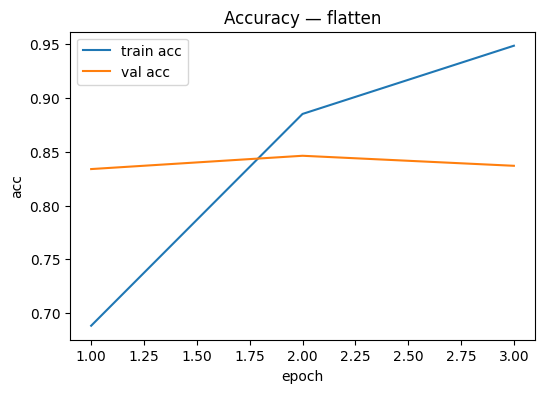

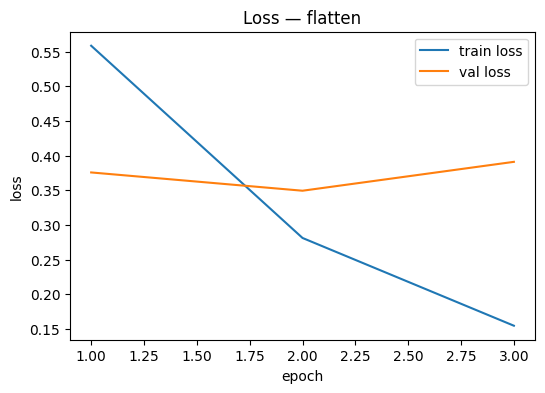

In [6]:
EPOCHS=3
hist_flat = m_flat.fit(train_vec, epochs=EPOCHS, validation_data=test_vec)
plot_and_save(hist_flat, 'flatten')

## Model 2 — BiLSTM

In [7]:
EMBED=64; L1=64; DENSE=64
m_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBED, input_length=SEQ_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(L1)),
    tf.keras.layers.Dense(DENSE, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
m_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
m_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
196/196 ━━━━━━━━━━━━━━━━━━━━ 44s 214ms/step - accuracy: 0.7670 - loss: 0.4650 - val_accuracy: 0.8315 - val_loss: 0.3942
Epoch 2/3
196/196 ━━━━━━━━━━━━━━━━━━━━ 51s 258ms/step - accuracy: 0.8935 - loss: 0.2758 - val_accuracy: 0.8552 - val_loss: 0.3552
Epoch 3/3
196/196 ━━━━━━━━━━━━━━━━━━━━ 52s 262ms/step - accuracy: 0.9203 - loss: 0.2171 - val_accuracy: 0.8325 - val_loss: 0.4049


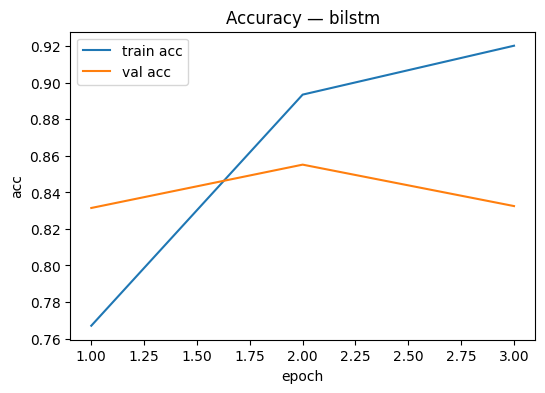

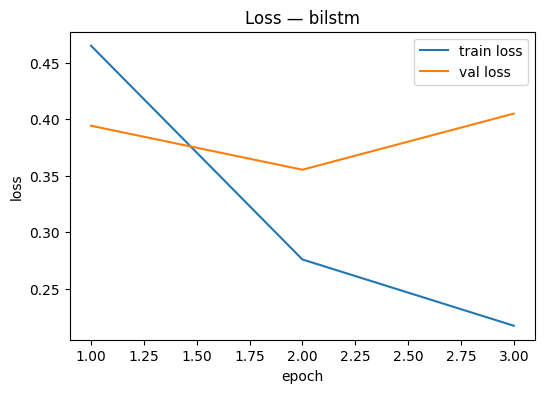

In [8]:
EPOCHS=3
cb=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)]
hist_lstm = m_lstm.fit(train_vec, epochs=EPOCHS, validation_data=test_vec, callbacks=cb)
plot_and_save(hist_lstm, 'bilstm')

## Model 3 — BiGRU

In [9]:
EMBED=64; G1=64; DENSE=64
m_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBED, input_length=SEQ_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(G1)),
    tf.keras.layers.Dense(DENSE, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
m_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
m_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.6957 - loss: 0.5476 - val_accuracy: 0.8200 - val_loss: 0.4167
Epoch 2/3
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 226ms/step - accuracy: 0.8730 - loss: 0.3187 - val_accuracy: 0.8224 - val_loss: 0.3993
Epoch 3/3
196/196 ━━━━━━━━━━━━━━━━━━━━ 49s 249ms/step - accuracy: 0.9064 - loss: 0.2440 - val_accuracy: 0.8245 - val_loss: 0.4192


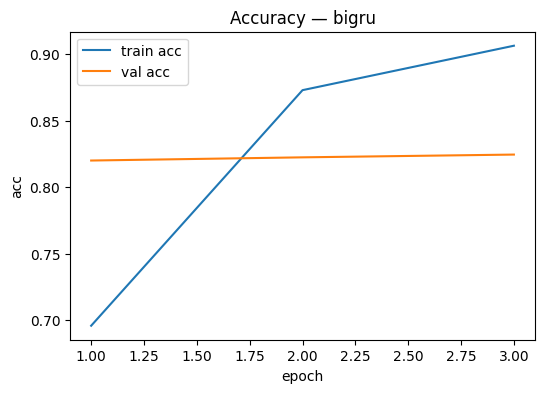

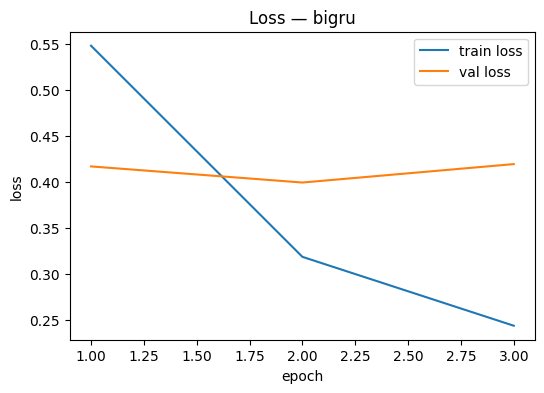

In [10]:
EPOCHS=3
cb=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)]
hist_gru = m_gru.fit(train_vec, epochs=EPOCHS, validation_data=test_vec, callbacks=cb)
plot_and_save(hist_gru, 'bigru')

## Model 4 — Conv1D + GlobalAveragePooling1D

In [11]:
EMBED=64; FILTERS=128; K=5; DENSE=64
m_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBED, input_length=SEQ_LEN),
    tf.keras.layers.Conv1D(FILTERS, K, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(DENSE, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
m_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
m_cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.7785 - loss: 0.4530 - val_accuracy: 0.8519 - val_loss: 0.3497
Epoch 2/3
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.8962 - loss: 0.2571 - val_accuracy: 0.8367 - val_loss: 0.3858
Epoch 3/3
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.9208 - loss: 0.2051 - val_accuracy: 0.8507 - val_loss: 0.3530


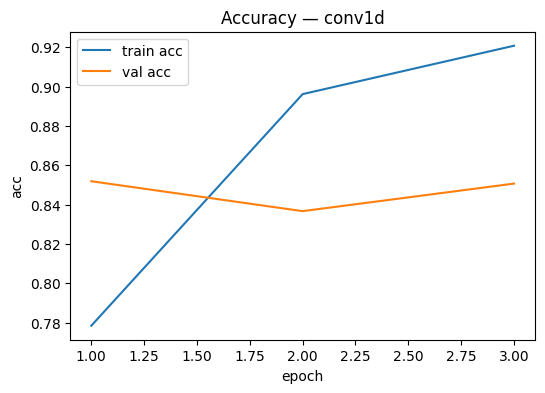

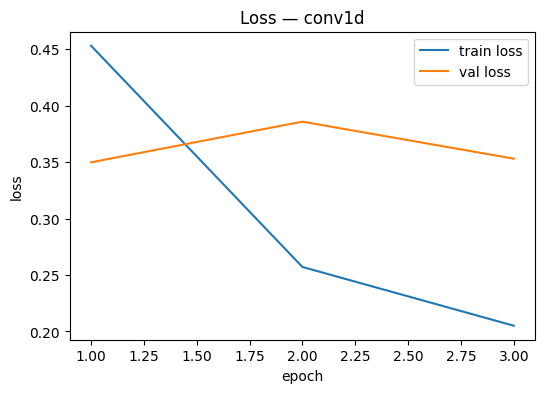

In [12]:
EPOCHS=3
hist_cnn = m_cnn.fit(train_vec, epochs=EPOCHS, validation_data=test_vec)
plot_and_save(hist_cnn, 'conv1d')

## Save models

In [13]:
ts = datetime.now().strftime('%Y%m%d_%H%M%S')
m_flat.save(f'artifacts/flat_{ts}.keras')
m_lstm.save(f'artifacts/bilstm_{ts}.keras')
m_gru.save(f'artifacts/bigru_{ts}.keras')
m_cnn.save(f'artifacts/conv1d_{ts}.keras')
print('Saved models to artifacts/.')

Saved models to artifacts/.


## Notes
- All models share the same TextVectorization layer for fair comparison.
- Increase `EPOCHS`, `SEQ_LEN`, or embedding size to see different trade-offs.
- BiGRU often trains faster than BiLSTM with similar accuracy; Conv1D is fast but misses long-range order.